In [98]:
# 주식 종목 불러오는 패키지
!pip install finance-datareader

In [99]:
import FinanceDataReader as fdr

# 삼성전자

In [100]:
# 삼성전자로 세팅됨, 종목번호 및 기간 바꿔서 진행
df = fdr.DataReader('005930', '2023-01-01', '2024-07-31')
df.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2024-07-25,80400,81000,80100,80400,20323811,-0.019512
2024-07-26,80700,81300,80400,80900,14508334,0.006219
2024-07-29,81600,82000,81100,81200,12797136,0.003708
2024-07-30,80400,81000,80000,81000,13169636,-0.002463
2024-07-31,81200,83900,80900,83900,20744323,0.035802


# 분석 코드

In [101]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [102]:
# GPU 꼭 연결해서 사용하세요~!
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

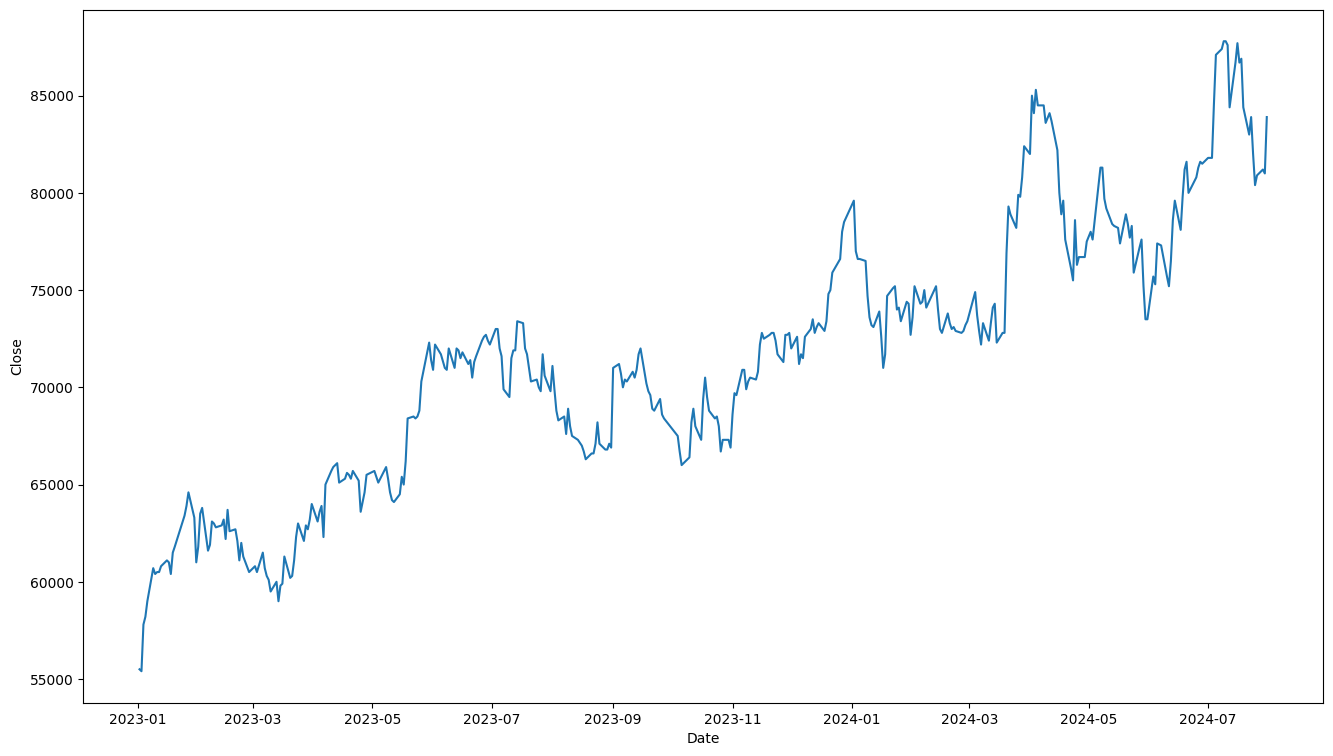

In [103]:
plt.figure(figsize=(16, 9))
sns.lineplot(x=df.index, y='Close', data=df)
plt.show()

# 데이터 전처리

In [104]:
#종가 제외 스케일링 (반응변수 = 종가)
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Volume']] = scaler.fit_transform(df[['Open','High', 'Low','Volume']])

# 예측 성능이 지나치게 낮아 종속변수도 스케일링을 진행 변수들의 크기가치가 너무 커 충분한 학습이 안됨.
# 종속 변수 'Close'도 스케일링
scaler_y = MinMaxScaler() # 종가 스케일링을 위한 별도의 스케일러
df['Close'] = scaler_y.fit_transform(df[['Close']]) # 'Close' 컬럼 스케일링

In [105]:
#넘파이 배열로 변경
x = df[['Open', 'High', 'Low', 'Volume']].values # 4개 체널
y = df['Close'].values # 1개 반응변수 (스케일링된 값)

#시퀀스 데이터 생성
def seq_data(x, y, sequence_length): #Sequence_legnth = time steps
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[ i : i + sequence_length]) # 시계열 데이터로 time step 만큼 X를 취함
    y_seq.append(y[i + sequence_length]) # X 만큼 뒤의 종가의 데이터 포인트를 타겟으로 봄.

  #gpu용 텐서로 변환
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)

In [106]:
split = 200
sequence_length=5 # 5일치씩 묶기
x_seq, y_seq = seq_data(x, y, sequence_length)

#앞의 split개는 학습, 나머지는 평가
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print("train : ", x_train_seq.size(), y_train_seq.size())
print("test : ", x_test_seq.size(), y_test_seq.size())

train :  torch.Size([200, 5, 4]) torch.Size([200, 1])
test :  torch.Size([184, 5, 4]) torch.Size([184, 1])


In [107]:
x_train_seq[:5] # 4개 체널의 값이 5개의 타임 스텝의 형태로 구성

tensor([[[0.0030, 0.0030, 0.0215, 0.0811],
         [0.0000, 0.0000, 0.0000, 0.1489],
         [0.0091, 0.0610, 0.0337, 0.2769],
         [0.0846, 0.0854, 0.0951, 0.1901],
         [0.0876, 0.1037, 0.1043, 0.2219]],

        [[0.0000, 0.0000, 0.0000, 0.1489],
         [0.0091, 0.0610, 0.0337, 0.2769],
         [0.0846, 0.0854, 0.0951, 0.1901],
         [0.0876, 0.1037, 0.1043, 0.2219],
         [0.1299, 0.1433, 0.1564, 0.2471]],

        [[0.0091, 0.0610, 0.0337, 0.2769],
         [0.0846, 0.0854, 0.0951, 0.1901],
         [0.0876, 0.1037, 0.1043, 0.2219],
         [0.1299, 0.1433, 0.1564, 0.2471],
         [0.1450, 0.1555, 0.1656, 0.1742]],

        [[0.0846, 0.0854, 0.0951, 0.1901],
         [0.0876, 0.1037, 0.1043, 0.2219],
         [0.1299, 0.1433, 0.1564, 0.2471],
         [0.1450, 0.1555, 0.1656, 0.1742],
         [0.1692, 0.1585, 0.1779, 0.1251]],

        [[0.0876, 0.1037, 0.1043, 0.2219],
         [0.1299, 0.1433, 0.1564, 0.2471],
         [0.1450, 0.1555, 0.1656, 0.1742],
   

In [108]:
y_train_seq[:5]

tensor([[0.1636],
        [0.1543],
        [0.1574],
        [0.1574],
        [0.1667]], device='cuda:0')

In [109]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq) #tensor 형태 데이터를 병합
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 5
# 한번에 처리할 독립적인 시계열 샘플의 수 = batch_size
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size)

# Vanila RNN
## 모델 구축

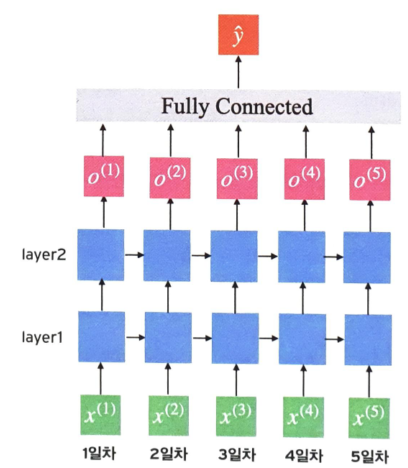

In [110]:
#기본 하이퍼 파라미터 설정
input_size = x_seq.size(2) #channel의 수
num_layers = 2
hidden_size = 8

In [111]:
class VanillaRNN(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__() # pytorch 초기화 방식
    self.device = device
    self.hidden_size = hidden_size # 은닉 상태 벡터의 차원;
    # RNN의 구조상 현재 시점의 입력 데이터와 이전 시점의 은닉 상태를 받아 계산을 수행
    # 이때 이전 시점의 은닉 상태를 8 차원의 하이퍼 파라미터를 설정하여
    # 과거 시점의 정보(5일치의 주가 데이터에서 추출된 특징들과 이전시점까지의 정보를 요약한 내용)
    # 를 요약하여 보여주는 것이라 생각하면 되겠다.
    self.num_layers = num_layers # RNN 레이어의 깊이
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) #한 줄로 모델 정의
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid())
    # RNN 층에서 나온 결과를 fc 층으로 전달해서 예측값 계산
    # 아래 forward에서 RNN에서 나오는 차원이 hidden_size * sequence_length, 1

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) #초기값 0으로 설정
    out,_ = self.rnn(x, h0) # 입력텐서 x가 sequence_length를 포함하고 있음. (batch_size, sequence_length, input_size)
    # self.rnn : output(모든 타입 스텝에서 계산된 가장 상위 레이어의 은닉상태), hidden(마지막 시점의 모든 레이어 은닉 상태 = 시퀀스 끝났을때의 모든 레이어의 은닉상태)을 출력 반환
    # RNN out은 기본적으로 (batch_size, sequence_length, hidden_size) 형태
    out = out.reshape(out.shape[0], -1) # 배치 사이즈를 제외한 나머지 차원을 모두 flatten
    #sequeence_length, hidden_layer를 펼침
    out = self.fc(out) # 이 형태로 fc에 먹이고 받음
    return out

In [112]:
model = VanillaRNN(input_size=input_size,
                   hidden_size = hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

In [113]:
criterion = nn.MSELoss()
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 모델 학습

In [114]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0

  for data in train_loader:
    seq, target = data #배치 데이터
    out = model(seq) #출력값 계산
    loss = criterion(out, target) #손실함수 계산

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() #최적화
    running_loss += loss.item()

  loss_graph.append(running_loss/n)
  if epoch % 10 ==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n)) # loss가 너무 큰데

[epoch : 0] loss: 0.0215
[epoch : 10] loss: 0.0020
[epoch : 20] loss: 0.0017
[epoch : 30] loss: 0.0016
[epoch : 40] loss: 0.0014


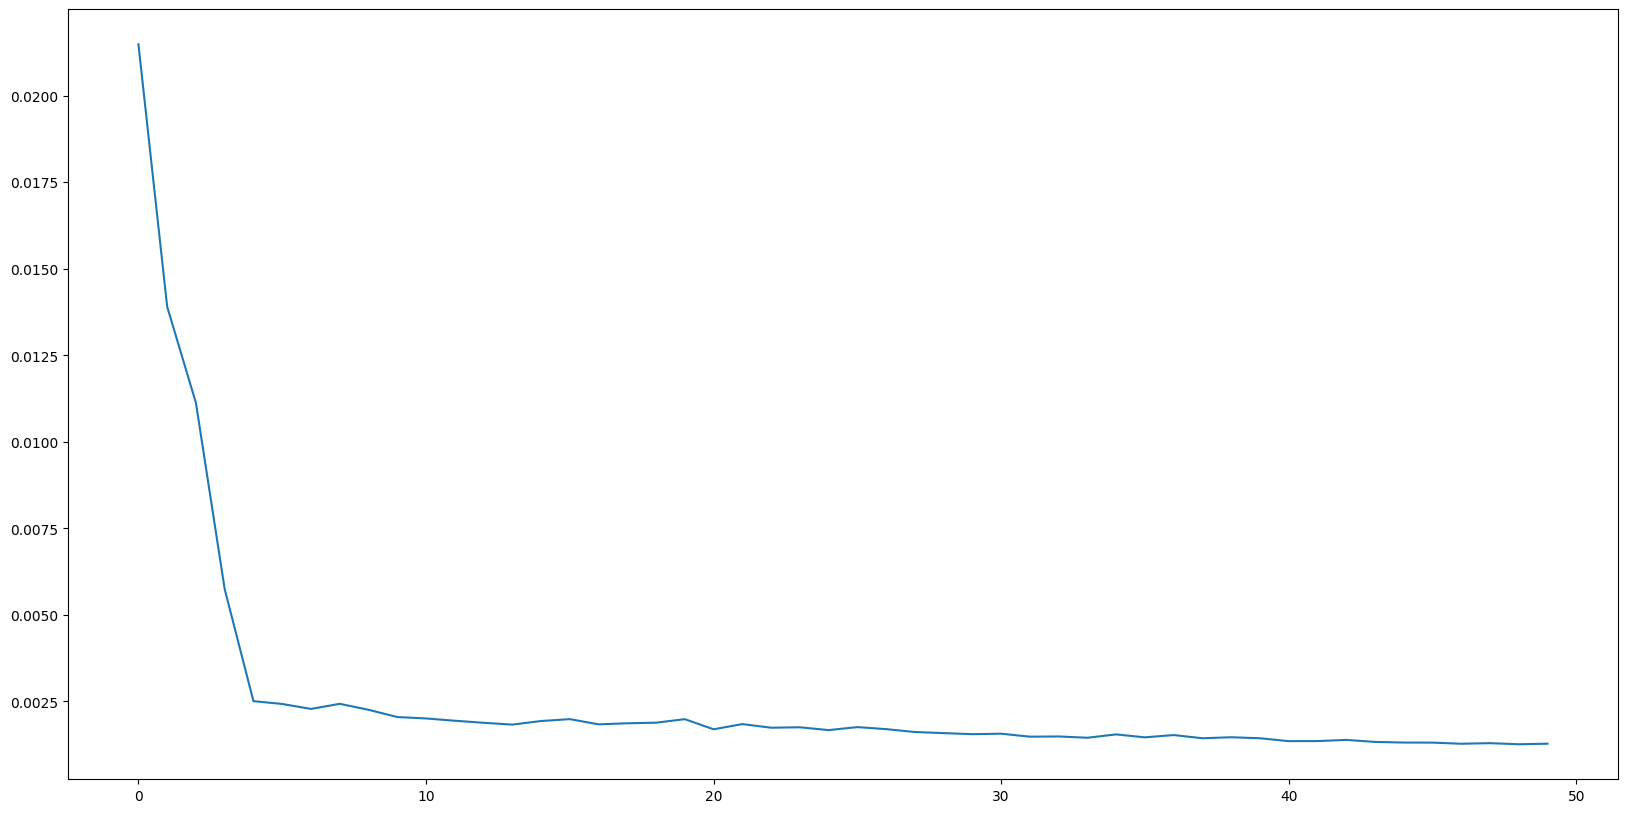

In [115]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

## 실제값과 예측값 비교

In [116]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100)

with torch.no_grad():
  pred = []
  model.eval()
  for data in data_loader:
    seq, target = data
    out = model(seq)
    pred += out.cpu().tolist()

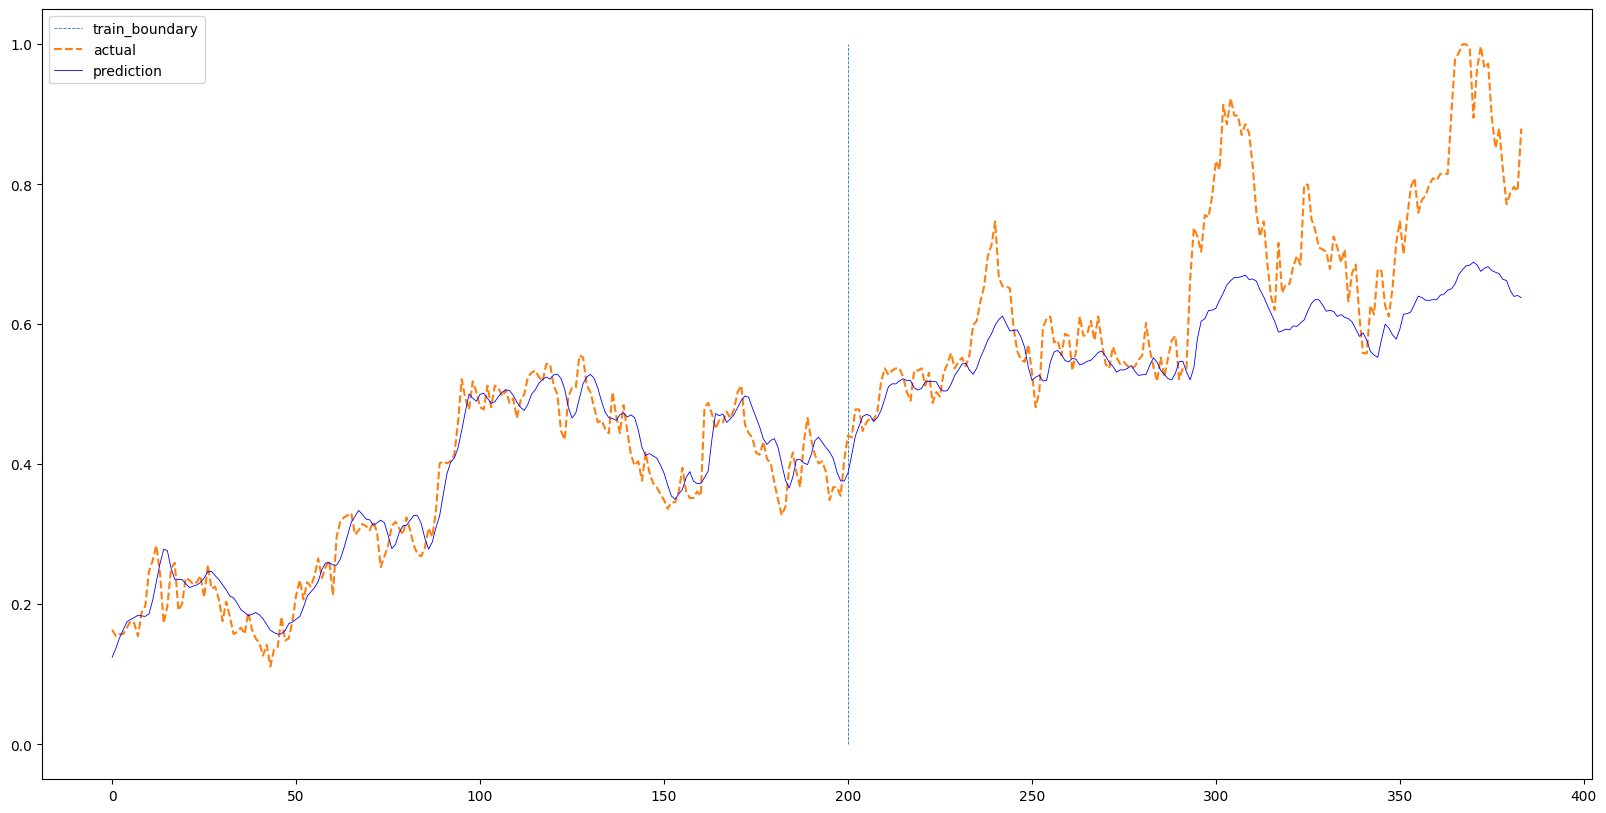

In [117]:
plt.figure(figsize = (20,10))
plt.plot(np.ones(100)*len(train), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred, 'b', linewidth = 0.6)
plt.legend(['train_boundary','actual','prediction'])
plt.show()

In [118]:
# 스케일링된 예측값을 원래 스케일로 되돌림
pred_original_scale = scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))

In [119]:
display(pred_original_scale[:5])

array([[59430.7682395 ],
       [59837.46681809],
       [60324.45367575],
       [60695.07568479],
       [61067.03504324]])

In [120]:
#df['Close'] = scaler_y.fit_transform(df[['Close']]) # 'Close' 컬럼 스케일링
df['Close_re']= scaler_y.inverse_transform(np.array(df['Close']).reshape(-1, 1))

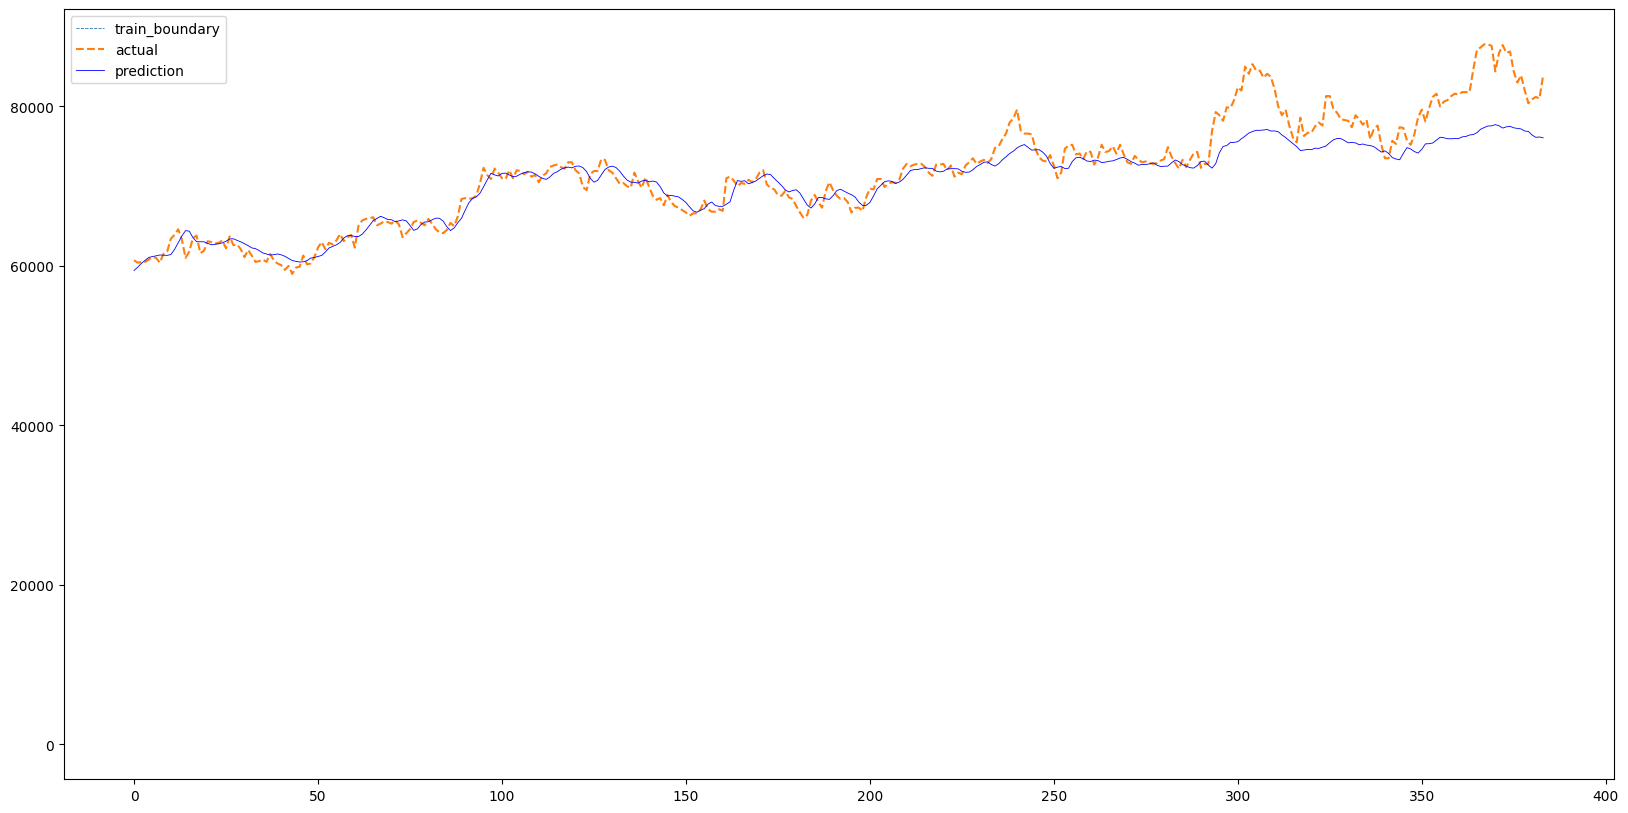

In [121]:
plt.figure(figsize = (20,10))
plt.plot(np.ones(100)*len(train), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(df['Close_re'][sequence_length:].values,'--')
plt.plot(pred_original_scale , 'b', linewidth = 0.6)
plt.legend(['train_boundary','actual','prediction'])
plt.show()

# LSTM
## 모델구축

In [122]:
#하이퍼 파라미터 정의
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [123]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size*sequence_length ,1)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out, _ = self.lstm(x,(h0,c0))
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [124]:
model = LSTM(input_size = input_size,
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers = num_layers,
             device=device).to(device)

In [125]:
criterion = nn.MSELoss()
num_epochs =50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [126]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 10 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))


[epoch: 0] loss: 0.2452
[epoch: 10] loss: 0.0027
[epoch: 20] loss: 0.0019
[epoch: 30] loss: 0.0018
[epoch: 40] loss: 0.0018


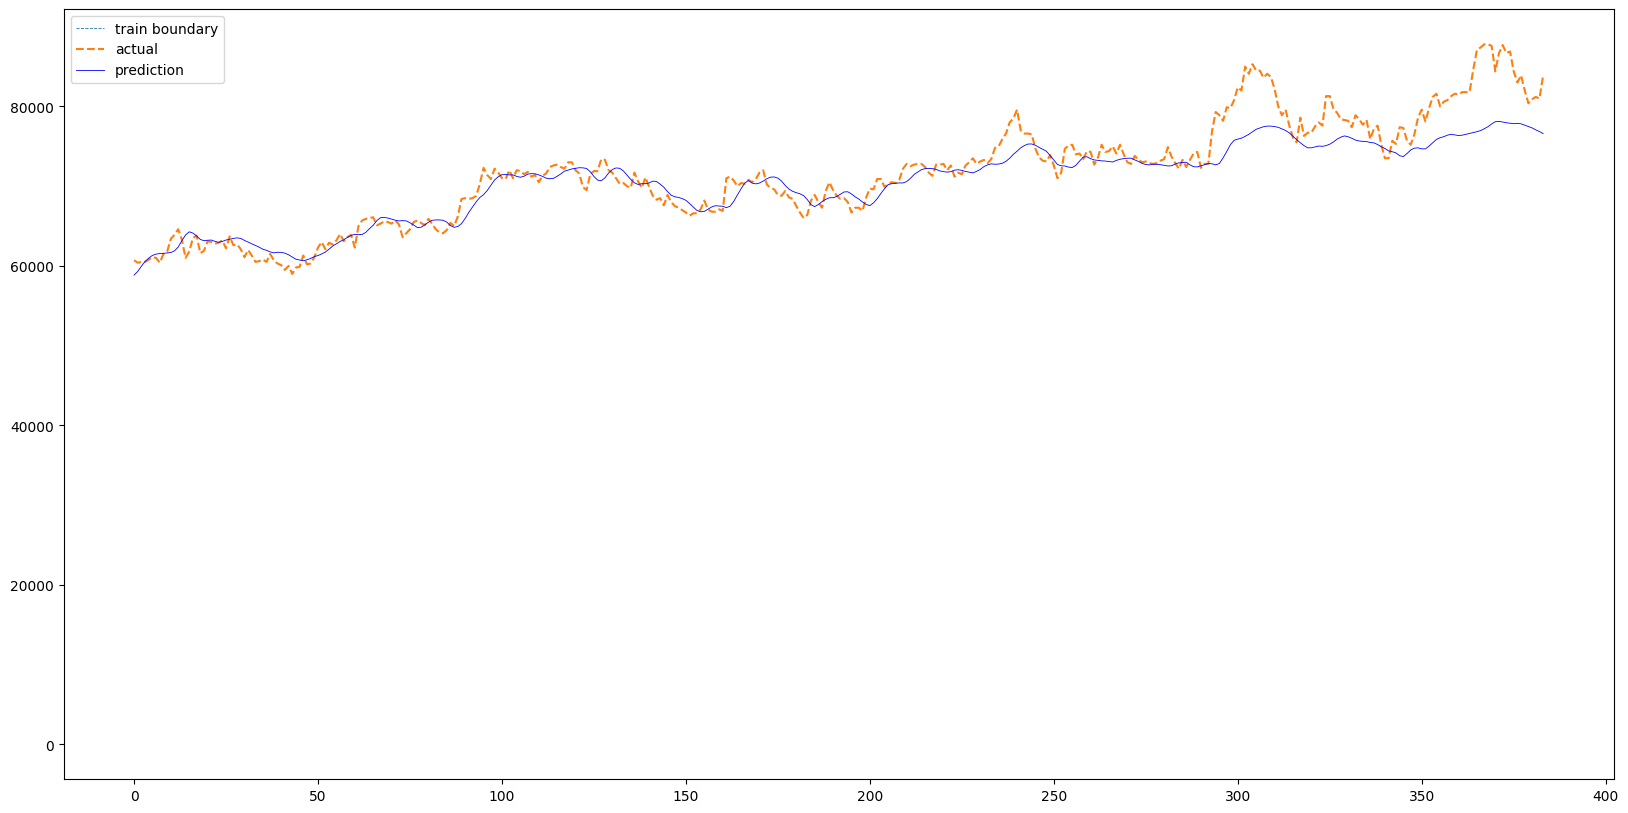

In [127]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100, shuffle=False)

with torch.no_grad():
    pred = []
    model.eval()
    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

# 스케일링된 예측값을 원래 스케일로 되돌림
pred_original_scale = scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))


plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(df['Close'][sequence_length:].min(),df['Close'][sequence_length:].max(),100),'--', linewidth=0.6) # y축 범위 조정
plt.plot(scaler_y.inverse_transform(df['Close'][sequence_length:].values.reshape(-1,1)),'--') # 실제값도 원래 스케일로 되돌림
plt.plot(pred_original_scale, 'b', linewidth=0.6)
plt.legend(['train boundary','actual','prediction'])
plt.show()

# (Optional)

현대 자동차 주가에 대한 정보에 같은 분석을 해봅시다. 다음 코드를 한 번 실행한 뒤, 분석 코드부터 다시 그대로 돌려보시기 보고 결과에 대해 자유롭게 해석해보시기 바랍니다.

In [128]:
# 현대자동자 주가로 세팅됨, 종목번호 및 기간 바꿔서 진행
df = fdr.DataReader('005380', '2024-01-01', '2025-12-31')
df.tail

<bound method NDFrame.tail of               Open    High     Low   Close   Volume    Change
Date                                                         
2024-01-02  202000  202500  199800  200500   373050 -0.014742
2024-01-03  199100  199500  193800  193800   548675 -0.033416
2024-01-04  192000  192800  189100  190000   505979 -0.019608
2024-01-05  190100  190500  187200  187300   440219 -0.014211
2024-01-08  187600  188900  185500  185700   323498 -0.008542
...            ...     ...     ...     ...      ...       ...
2025-07-15  217000  217500  209500  211000  1111748 -0.027650
2025-07-16  211000  211000  207500  207500   492782 -0.016588
2025-07-17  208500  212000  205500  210000   611349  0.012048
2025-07-18  210000  212500  208500  210500   317353  0.002381
2025-07-21  209500  210500  208000  209000   460770 -0.007126

[377 rows x 6 columns]>